In [123]:
import sys
sys.path.append('..')
import pretty_midi
from note import MIDI_note
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch
import processing

def create_canvas(midi_notes):
    # Assume tempo_times and tempo_bpm are defined
    largest_time_end = int(max(note.time_end for note in midi_notes))
    song_canvas = np.zeros((4, 128, largest_time_end), dtype=float)  # Use dtype=float for flexibility

    for idx, n in enumerate(midi_notes):
        tempo = int(n.tempo)
        start = int(n.time_start)  # Convert time_start to integer
        end = int(n.time_end)  # Convert time_end to integer

        # Ensure indices are within the bounds of the canvas
        if end > largest_time_end:
            end = largest_time_end

        # Fill the song_canvas with the respective values
        song_canvas[0, n.pitch, start:end] = (n.channel + 1)
        song_canvas[1, n.pitch, start:end] = n.dynamic
        song_canvas[2, n.pitch, start] = 1  # Mark note start
        song_canvas[3, n.pitch, start:end] = tempo

    return song_canvas

def show_canvas(song_canvas, feature_idx, pitch_bounds=None, time_bounds=None):
    if time_bounds is not None:
        lower_bound, upper_bound = time_bounds
        array_2d = np.flipud(song_canvas[feature_idx].squeeze()[:, lower_bound:upper_bound])  # Shape becomes (128, 1000) with pitch flipped
    else:
        array_2d = np.flipud(song_canvas[feature_idx].squeeze()[:, :])  # Shape becomes (128, 1000) with pitch flipped

    if pitch_bounds is not None:
        lower_bound, upper_bound = pitch_bounds
        array_2d = array_2d.squeeze()[lower_bound:upper_bound, :]  # Shape becomes (128, 1000) with pitch flipped
    else:
        array_2d = array_2d.squeeze()[:, :]  # Shape becomes (128, 1000) with pitch flipped

    # Set the minimum value to 0 and normalize to the range [0, 1] for visualization
    # array_2d = (array_2d - np.min(array_2d)) / (np.max(array_2d) - np.min(array_2d))

    # Create a custom colormap with black for 0 and bright colors for higher values
    from matplotlib.colors import LinearSegmentedColormap
    custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [(0, "black"), (1 / 128, "blue"), (1, "yellow")])

    # Visualize the array as an image
    plt.figure(figsize=(15, 5))  # Adjust figure size for large dimensions
    plt.imshow(array_2d, aspect='auto', cmap=custom_cmap)  # Display the image with a custom colormap
    plt.colorbar(label='Normalized Value')  # Add colorbar
    plt.xlabel('Time')
    plt.ylabel('Pitch')
    plt.title('Song Canvas Visualization with Enhanced Contrast')
    plt.show()


def midi2canvas(path):
    midi_notes= processing.extract_midi(path)
    processing.adjust_note_time(midi_notes)
    song_canvas = create_canvas(midi_notes)
    return song_canvas

def load_diffusion(midi_path):
    song_canvas = np.float32(np.load(midi_path))
    return song_canvas

def encode_midi_diffusion(midi_path, dataset_path):
    midi_files = []
    midi_file_names = []

    # Walk through the midi_path directory to gather MIDI files
    for root, dirs, files in os.walk(midi_path):
        for file in files:
            if file.lower().endswith(('.mid', '.midi')):
                name_without_extension = os.path.splitext(file)[0]  # Remove the extension
                # Check if the corresponding .npy file already exists
                if not os.path.exists(os.path.join(dataset_path, f'{name_without_extension}.npy')):
                    midi_files.append(os.path.join(root, file))
                    midi_file_names.append(name_without_extension)

    # Process and save the files that are not already in dataset_path
    for idx, path in enumerate(midi_files):
        song_canvas = midi2canvas(path)  # Convert MIDI to canvas
        np.save(os.path.join(dataset_path, f'{midi_file_names[idx]}.npy'), song_canvas)

class RandomSnippet(Dataset):
    def __init__(self, image, snippet_size, num_snippets):
        self.image = image
        self.snippet_size = snippet_size
        self.num_snippets = num_snippets
        self.max_start_idx = image[1,1,:].size - snippet_size

    def __len__(self):
        return self.num_snippets

    def __getitem__(self, idx):
        # Generate a random start index
        start = torch.randint(0, self.max_start_idx + 1, (1,)).item()
        end = start + self.snippet_size
        snippet = self.image[:, :, start:end]
        return snippet

In [120]:
encode_midi_diffusion('E:/GitHub/Deep-Learning-Based-Sequence-Models-for-Music-Generation/scripts/midi','E:/GitHub/Deep-Learning-Based-Sequence-Models-for-Music-Generation/scripts/npy')

In [125]:
song_canvas = load_diffusion("E:/GitHub/Deep-Learning-Based-Sequence-Models-for-Music-Generation/scripts/npy/generated_Beethoven_mamba_0.npy")

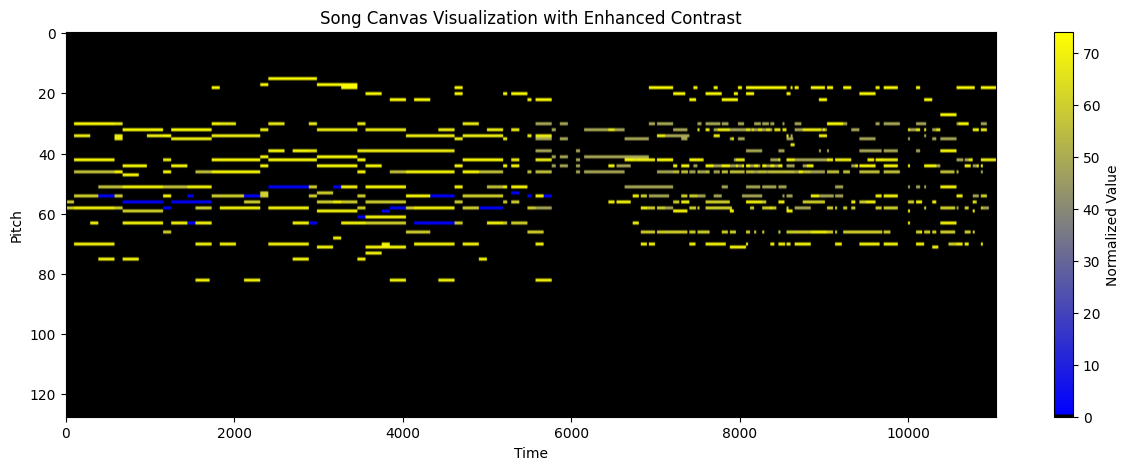

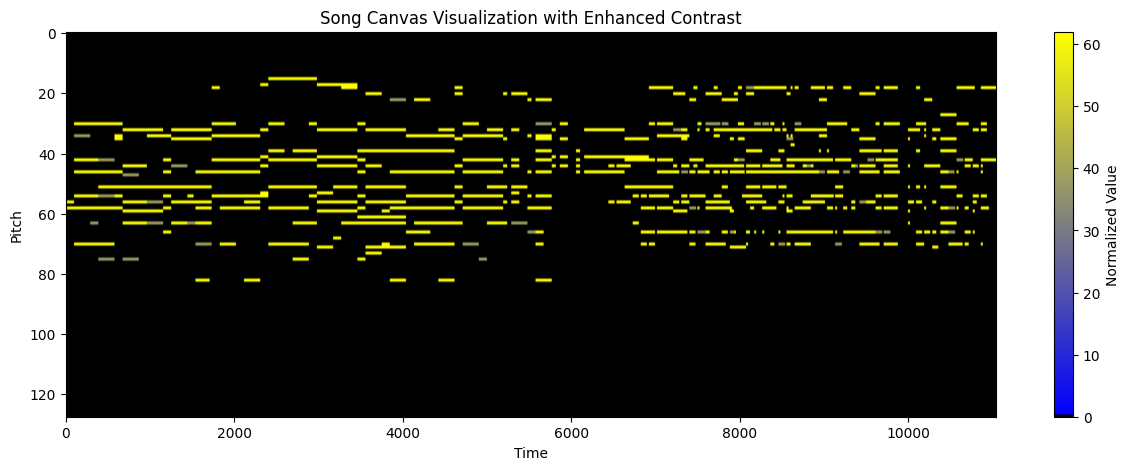

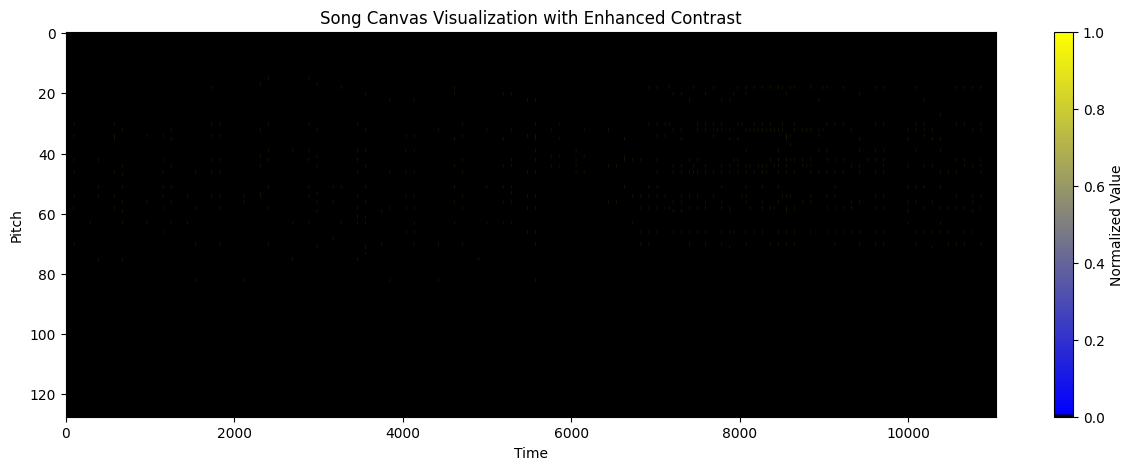

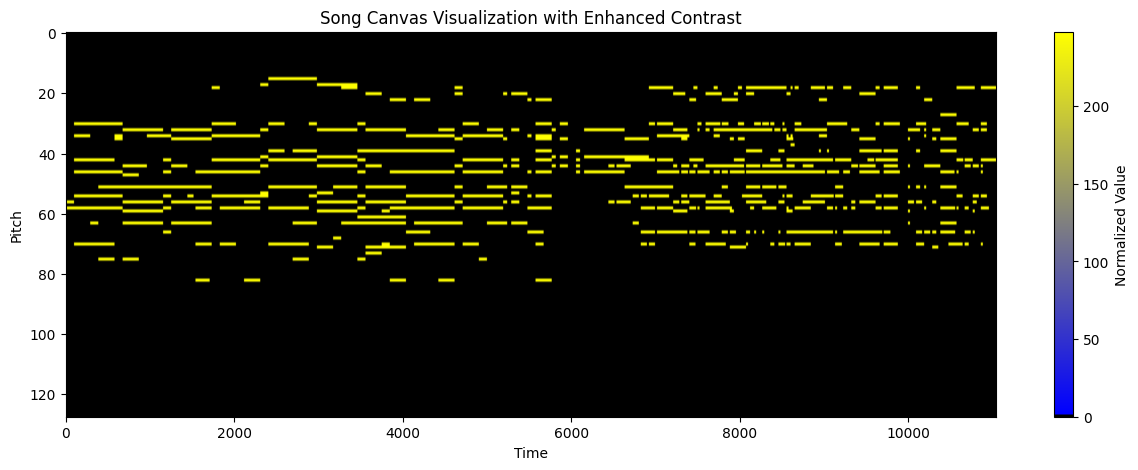

In [126]:
for i in range(4):
    show_canvas(song_canvas,i)